In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce
import seaborn as sns
from typing import List

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql import Window
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, lag, lead, avg, count, unix_timestamp
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 60000) \
        .set('spark.network.timeout', 60000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab_1_var_5") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

directory_path = "data/"

file_list = [file for file in os.listdir(directory_path) if file.endswith(".csv")]

# Чтение файлов и создание DataFrame с явным указанием разделителя
dataframes = [spark.read.csv(os.path.join(directory_path, file), header=True, inferSchema=True, sep=';') for file in file_list]

# Объединение DataFrame в один
merged_dataframe = reduce(DataFrame.union, dataframes)

# Вывод первых строк объединенного DataFrame
merged_dataframe.limit(5).toPandas().head()

,timestamp,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,pv_86,pv_87,pv_88,pv_89,pv_90,pv_91,pv_92,pv_93,pv_94,pv_95
0,2014-07-19 18:45:00,1,0,51.625703,22.712489,52.816828,53.501688,54.079161,52.683472,52.590445,...,81.286349,77.580181,58.433449,55.572970,53.792765,51.999028,43.290921,34.161343,28.349901,24.636241
1,2014-07-19 19:30:00,1,0,52.281257,6.618605,51.452796,51.676287,51.329882,51.690879,51.538671,...,55.571058,53.791009,51.997415,43.289440,34.159983,28.348652,24.635094,19.147728,12.982840,7.928666
2,2014-07-19 20:00:00,1,0,50.719565,1.452209,51.313898,52.199835,52.340547,51.844138,52.661063,...,51.996045,43.288181,34.158827,28.347590,24.634119,19.146832,12.982018,7.927911,5.622566,3.299011
3,2014-07-19 20:15:00,1,0,51.901162,0.580877,51.950475,51.624345,50.867434,51.538997,51.331161,...,43.288060,34.158716,28.347489,24.634026,19.146747,12.981939,7.927839,5.622499,3.298950,2.130662
4,2014-07-19 21:00:00,1,0,51.250007,0.000000,52.218820,52.176852,51.745211,51.809854,51.835710,...,24.633942,19.146670,12.981869,7.927774,5.622440,3.298896,2.130612,1.352937,1.246175,1.246205


In [3]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (nullable = true

Так как столбцы load_XX - показатели прогноза нагрузки потребления за каждые 15 минут, а pv_XX - прогноз произведенного фотоэлектричества на каждые 15 минут, оставим из них каждый пятый столбец для дальнейшего машинного обучения

In [4]:
merged_dataframe = merged_dataframe.select('timestamp', 'site_id', 'period_id', 
                                           'actual_consumption', 'actual_pv', 
                                           'load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 
                                           'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95')

In [5]:
# Вывод количества строк до удаления пустых значений
merged_dataframe.count()

962282

In [6]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = merged_dataframe.dropna()

# Вывод количество строк после удаления пустых значений
cleaned_dataframe.count()

962282

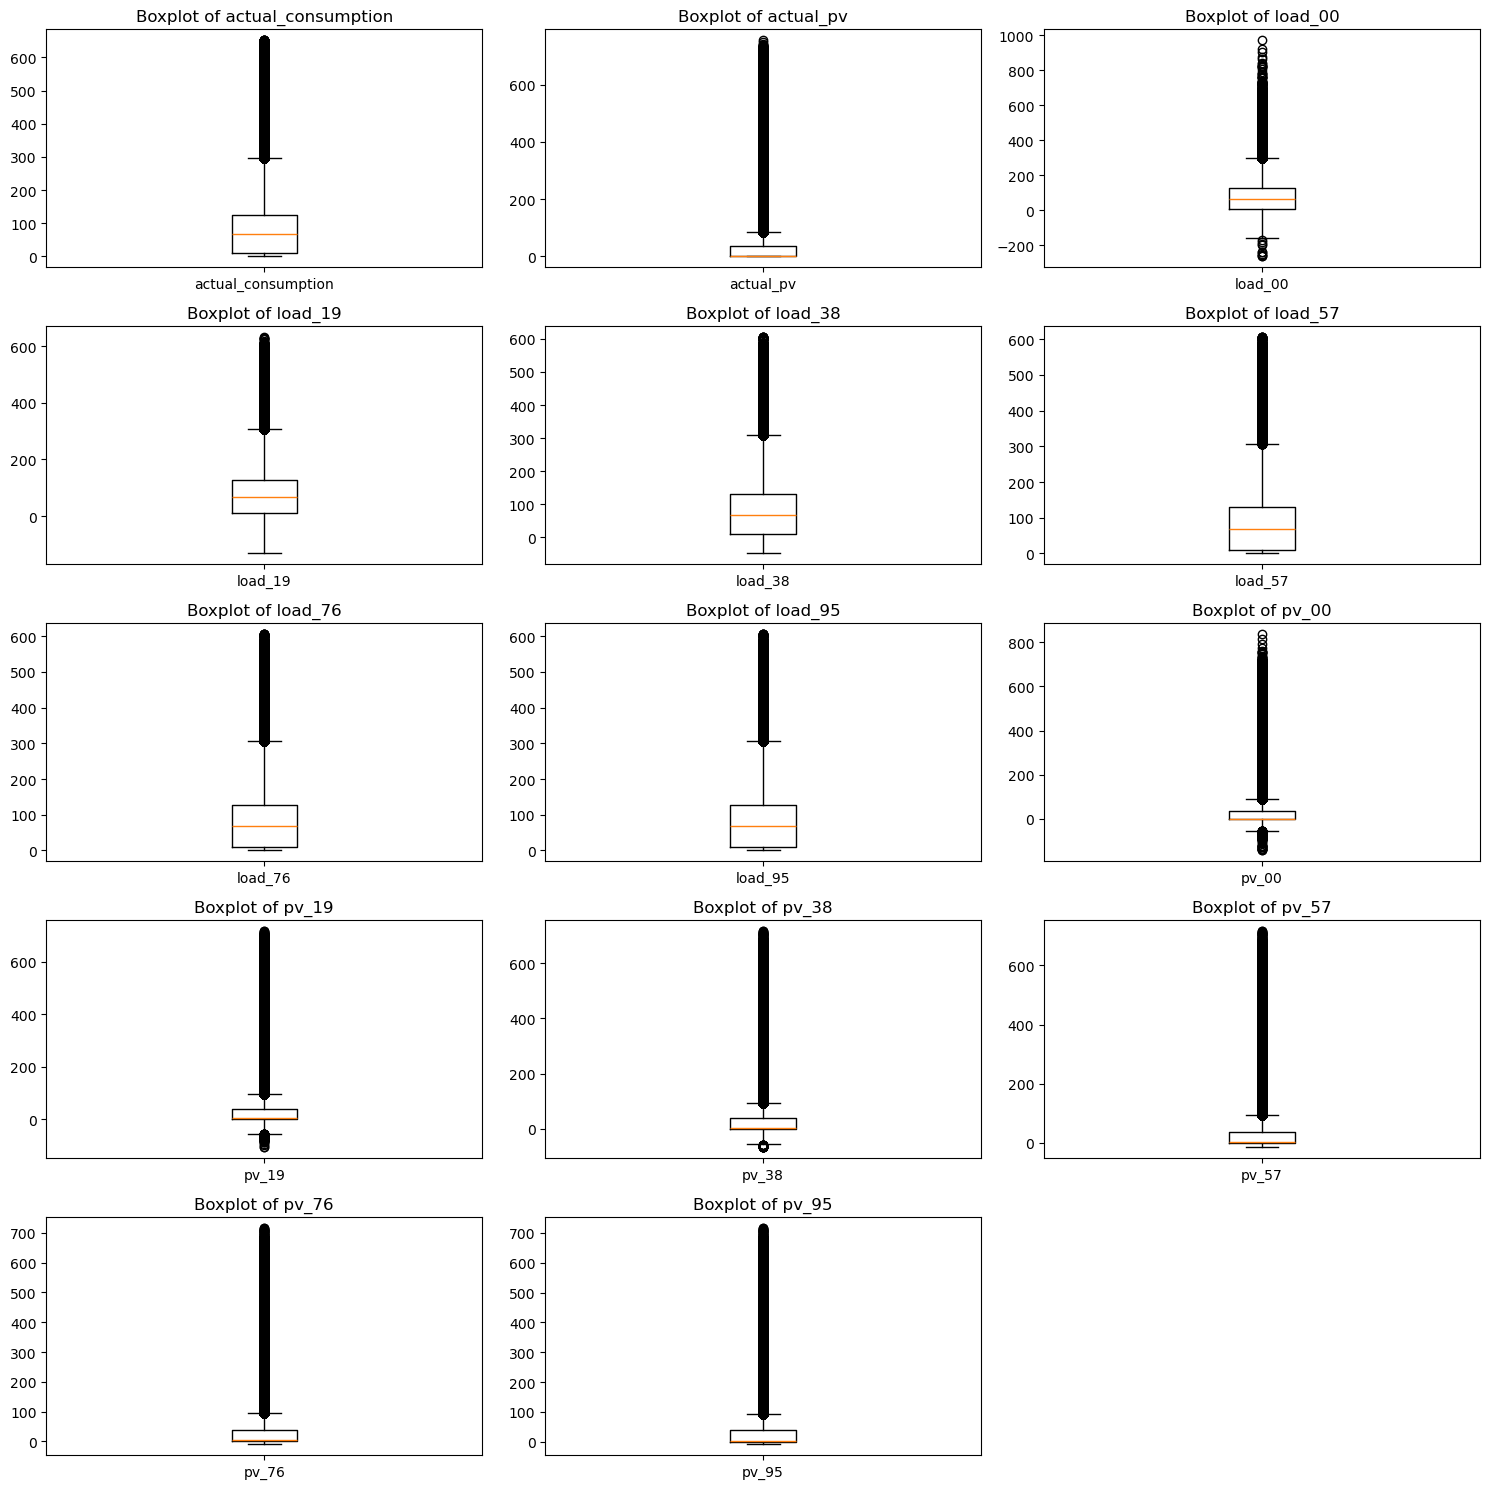

In [7]:
def print_columns_box_plotes(dataframe: DataFrame, columns_to_print: List[str], number_of_cols:int = 3) -> None:  
    # Определение количества строк и столбцов для Subplots
    num_rows = len(columns_to_print) // number_of_cols + (len(columns_to_print) % number_of_cols > 0)
    fig, axs = plt.subplots(num_rows, number_of_cols, figsize=(15, 3 * num_rows))
    
    for i, column in enumerate(columns_to_print):
        # Построение boxplot
        axs[i // number_of_cols, i % number_of_cols].boxplot([dataframe.select(column).rdd.flatMap(lambda x: x).collect()], labels=[column])
        axs[i // number_of_cols, i % number_of_cols].set_title(f'Boxplot of {column}')
    
    # Убираем пустые подграфики, если количество не кратно number_of_cols
    for i in range(len(columns_to_print), num_rows * number_of_cols):
        fig.delaxes(axs.flatten()[i])
    
    # Регулировка расположения подграфиков
    plt.tight_layout()
    
    # Отображение графика
    plt.show()


# Список столбцов для обработки
columns_to_filter = ['actual_consumption', 'actual_pv', 'load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95']
print_columns_box_plotes(cleaned_dataframe, columns_to_filter)


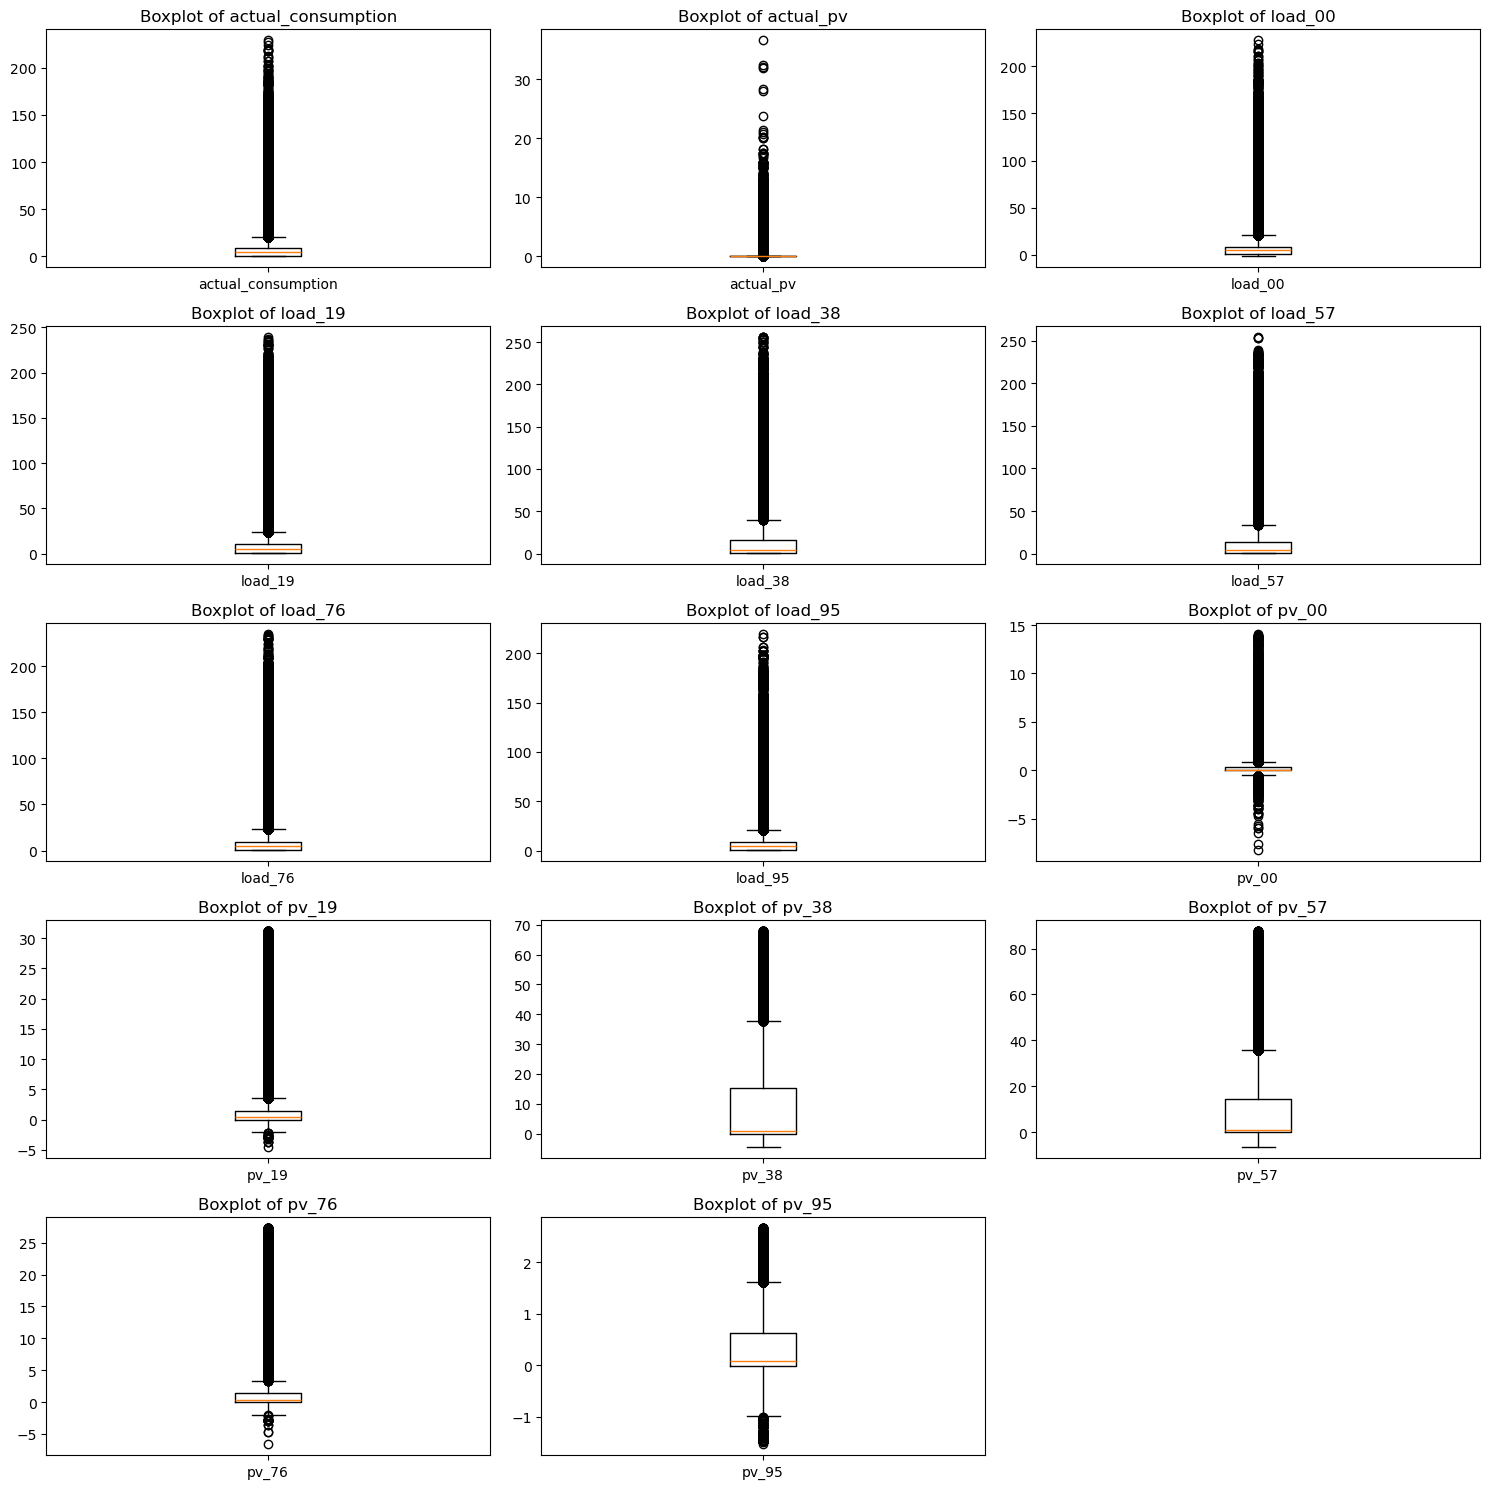

In [8]:
# Фильтрация выбросов для каждого столбца
for column in columns_to_filter:
    # Рассчет квартилей
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет межквартильного размаха
    IQR = quartiles[1] - quartiles[0]

    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

print_columns_box_plotes(cleaned_dataframe, columns_to_filter)

In [9]:
# Расчет статистических показателей
statistics_summary = cleaned_dataframe.describe()
# Вывод сводной статистики
statistics_summary.toPandas()

,summary,site_id,period_id,actual_consumption,actual_pv,load_00,load_19,load_38,load_57,load_76,load_95,pv_00,pv_19,pv_38,pv_57,pv_76,pv_95
0,count,254819,254819,254819,254819,254819,254819,254819,254819,254819,254819,254819,254819,254819,254819,254819,254819
1,mean,7.533347199384662,37.08056306633336,8.241730720002968,0.2384816059080903,8.28240439156897,10.170867552252348,12.997972264538348,12.387739022852177,10.005129596073203,8.275523072916062,0.3030200441359454,3.010309606099662,8.808847532365922,9.18974546724264,2.6253681481186013,0.3498973882155256
2,stddev,4.31092623942558,29.60656703811795,15.29755383359513,0.7000596636769986,15.291872263076373,19.016063591468054,24.341061796844333,23.222519677339285,18.894472199283427,15.231177634791852,0.7426208216054142,6.668173420739172,13.672174987557165,15.634927772627552,5.806304023448487,0.6401612988392137
3,min,1,0,0.14690635762456802,0.0,-1.595713077825396,0.2073588179345237,0.2073588179345237,0.2073588179345237,0.2073588179345237,0.2073588179345237,-8.286866276578548,-4.609828447617797,-4.6153179940941715,-6.646786127600455,-6.646786136585727,-1.5364529692303388
4,max,15,120,229.2530940431179,36.65371519027764,227.6593986263814,239.0330524823618,255.81618891827628,254.3845401545934,234.5331764093208,219.30898543413323,14.060874229313553,31.156101655620567,67.85215620432852,87.57135468283093,27.25726708585224,2.664145064021641


## Выводы по сводной статистике:

* site_id и period_id:
-- 
site_id имеет 937 250 записей, принимающих значения от 1 до 15.
period_id также имеет 937 250 записей, принимающих значения от 0 до 120.
Средние значения для обоих признаков близки к центральным значениям и варьируются в пределах разумных пределов для числовых идентификато
р* ов.
actual_consumption и actual_-- pv:

actual_consumption имеет среднее значение около 76.30 с стандартным отклонением 72.81.
actual_pv также имеет среднее значение около 44.22 с стандартным отклонением 99.05.
Стандартные отклонения для обоих признаков довольно велики, что может указывать на значительную вариацию 
в*  данных.
load_00, load_19, ...-- , pv_95:

Эти признаки представляют собой значения загрузки и производства энергии для различных временных интервалов.
Средние значения и стандартные отклонения для каждого из них варьируются, что может указывать на разные характеристики в разли
ч* ные периоды.
-- Общий вывод:

Для числовых признаков в данных присутствует значительная вариация, как указано стандартными отклонениями.
Значения min и max для некоторых признаков, таких как load_00 и pv_00, могут потребовать внимания, так как они могут содержать выбросы или аномалии.

Гистограммы распределения количественных признаков

(array([1.81641e+05, 4.41630e+04, 7.51600e+03, 8.63400e+03, 3.14500e+03,
        6.82000e+02, 1.30900e+03, 4.25800e+03, 4.15000e+02, 2.15000e+02,
        1.57000e+02, 4.38000e+02, 6.60000e+02, 4.04000e+02, 2.81000e+02,
        2.55000e+02, 1.96000e+02, 1.27000e+02, 8.70000e+01, 5.80000e+01,
        4.70000e+01, 3.90000e+01, 2.90000e+01, 1.40000e+01, 2.20000e+01,
        8.00000e+00, 6.00000e+00, 5.00000e+00, 5.00000e+00, 3.00000e+00]),
 array([1.46906358e-01, 7.78377928e+00, 1.54206522e+01, 2.30575251e+01,
        3.06943980e+01, 3.83312710e+01, 4.59681439e+01, 5.36050168e+01,
        6.12418897e+01, 6.88787627e+01, 7.65156356e+01, 8.41525085e+01,
        9.17893814e+01, 9.94262544e+01, 1.07063127e+02, 1.14700000e+02,
        1.22336873e+02, 1.29973746e+02, 1.37610619e+02, 1.45247492e+02,
        1.52884365e+02, 1.60521238e+02, 1.68158111e+02, 1.75794984e+02,
        1.83431857e+02, 1.91068729e+02, 1.98705602e+02, 2.06342475e+02,
        2.13979348e+02, 2.21616221e+02, 2.29253094e+02])

Text(0.5, 1.0, 'Distribution of actual_consumption')

Text(0.5, 0, 'actual_consumption')

Text(0, 0.5, 'Frequency')

(array([2.36831e+05, 1.61150e+04, 8.28000e+02, 3.08000e+02, 1.98000e+02,
        1.58000e+02, 1.08000e+02, 7.60000e+01, 6.20000e+01, 4.40000e+01,
        2.80000e+01, 1.30000e+01, 1.90000e+01, 9.00000e+00, 8.00000e+00,
        0.00000e+00, 4.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.        ,  1.22179051,  2.44358101,  3.66537152,  4.88716203,
         6.10895253,  7.33074304,  8.55253354,  9.77432405, 10.99611456,
        12.21790506, 13.43969557, 14.66148608, 15.88327658, 17.10506709,
        18.3268576 , 19.5486481 , 20.77043861, 21.99222911, 23.21401962,
        24.43581013, 25.65760063, 26.87939114, 28.10118165, 29.32297215,
        30.54476266, 31.76655316, 32.98834367, 34.21013418, 35.43192468,
        36.65371519]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of actual_pv')

Text(0.5, 0, 'actual_pv')

Text(0, 0.5, 'Frequency')

(array([1.39717e+05, 8.25910e+04, 9.13800e+03, 8.70100e+03, 4.82000e+03,
        8.07000e+02, 5.82000e+02, 4.43000e+03, 9.01000e+02, 2.11000e+02,
        1.92000e+02, 3.45000e+02, 6.57000e+02, 4.78000e+02, 3.05000e+02,
        2.19000e+02, 2.40000e+02, 1.44000e+02, 7.40000e+01, 5.90000e+01,
        6.30000e+01, 4.90000e+01, 2.70000e+01, 1.60000e+01, 2.30000e+01,
        1.00000e+01, 8.00000e+00, 5.00000e+00, 5.00000e+00, 2.00000e+00]),
 array([ -1.59571308,   6.04612398,  13.68796104,  21.32979809,
         28.97163515,  36.61347221,  44.25530926,  51.89714632,
         59.53898338,  67.18082043,  74.82265749,  82.46449455,
         90.1063316 ,  97.74816866, 105.39000572, 113.03184277,
        120.67367983, 128.31551689, 135.95735394, 143.599191  ,
        151.24102806, 158.88286512, 166.52470217, 174.16653923,
        181.80837629, 189.45021334, 197.0920504 , 204.73388746,
        212.37572451, 220.01756157, 227.65939863]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of load_00')

Text(0.5, 0, 'load_00')

Text(0, 0.5, 'Frequency')

(array([1.56496e+05, 6.81130e+04, 8.01100e+03, 8.03400e+03, 5.00800e+03,
        4.96000e+02, 3.41000e+02, 3.97300e+03, 1.26200e+03, 1.72000e+02,
        6.70000e+01, 2.84000e+02, 7.30000e+02, 4.98000e+02, 2.19000e+02,
        1.93000e+02, 3.20000e+02, 2.13000e+02, 5.90000e+01, 5.40000e+01,
        5.80000e+01, 6.80000e+01, 3.10000e+01, 3.50000e+01, 4.00000e+01,
        9.00000e+00, 1.70000e+01, 1.30000e+01, 2.00000e+00, 3.00000e+00]),
 array([2.07358818e-01, 7.51074637e+00, 1.48141339e+01, 2.21175215e+01,
        2.94209090e+01, 3.67242966e+01, 4.40276841e+01, 5.13310717e+01,
        5.86344592e+01, 6.59378468e+01, 7.32412344e+01, 8.05446219e+01,
        8.78480095e+01, 9.51513970e+01, 1.02454785e+02, 1.09758172e+02,
        1.17061560e+02, 1.24364947e+02, 1.31668335e+02, 1.38971722e+02,
        1.46275110e+02, 1.53578497e+02, 1.60881885e+02, 1.68185273e+02,
        1.75488660e+02, 1.82792048e+02, 1.90095435e+02, 1.97398823e+02,
        2.04702210e+02, 2.12005598e+02, 2.19308985e+02])

Text(0.5, 1.0, 'Distribution of load_95')

Text(0.5, 0, 'load_95')

Text(0, 0.5, 'Frequency')

(array([2.00000e+00, 0.00000e+00, 1.00000e+00, 4.00000e+00, 2.00000e+00,
        8.00000e+00, 1.10000e+01, 3.10000e+01, 6.90000e+01, 1.85000e+02,
        1.79720e+04, 1.94301e+05, 2.87830e+04, 9.59000e+03, 1.37800e+03,
        6.72000e+02, 4.89000e+02, 3.50000e+02, 2.02000e+02, 1.56000e+02,
        1.37000e+02, 9.60000e+01, 8.70000e+01, 6.60000e+01, 5.60000e+01,
        5.00000e+01, 3.70000e+01, 3.10000e+01, 2.50000e+01, 2.80000e+01]),
 array([-8.28686628, -7.54194159, -6.79701691, -6.05209223, -5.30716754,
        -4.56224286, -3.81731818, -3.07239349, -2.32746881, -1.58254412,
        -0.83761944, -0.09269476,  0.65222993,  1.39715461,  2.14207929,
         2.88700398,  3.63192866,  4.37685334,  5.12177803,  5.86670271,
         6.61162739,  7.35655208,  8.10147676,  8.84640144,  9.59132613,
        10.33625081, 11.0811755 , 11.82610018, 12.57102486, 13.31594955,
        14.06087423]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of pv_00')

Text(0.5, 0, 'pv_00')

Text(0, 0.5, 'Frequency')

(array([  745.,   798.,   909.,   190.,  1122.,   362.,  2472.,  5092.,
        11548., 14031., 51854., 45809., 11225., 14692., 13264., 22568.,
         8775.,  9720.,  5564.,  5965.,  5511.,  7289.,  3732.,  3402.,
         2866.,  1955.,   712.,  1137.,   940.,   570.]),
 array([-1.53645297, -1.39643303, -1.2564131 , -1.11639317, -0.97637323,
        -0.8363533 , -0.69633336, -0.55631343, -0.41629349, -0.27627356,
        -0.13625362,  0.00376631,  0.14378624,  0.28380618,  0.42382611,
         0.56384605,  0.70386598,  0.84388592,  0.98390585,  1.12392579,
         1.26394572,  1.40396565,  1.54398559,  1.68400552,  1.82402546,
         1.96404539,  2.10406533,  2.24408526,  2.3841052 ,  2.52412513,
         2.66414506]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of pv_95')

Text(0.5, 0, 'pv_95')

Text(0, 0.5, 'Frequency')

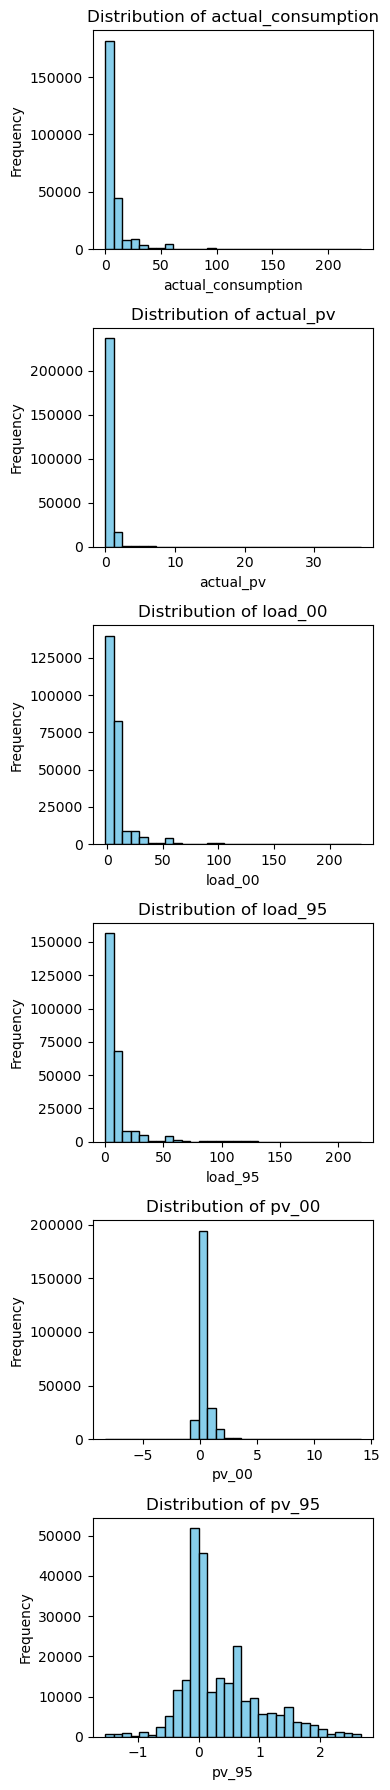

In [10]:
selected_features = ['actual_consumption', 'actual_pv', 'load_00', 'load_95', 'pv_00', 'pv_95'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(4, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    axs[i].hist(cleaned_dataframe.select(feature).rdd.flatMap(lambda x: x).collect(), bins=30, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

Гистограммы распределения категориальных признаков

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'Distribution of site_id')

Text(0.5, 0, 'site_id')

Text(0, 0.5, 'Count')

<BarContainer object of 121 artists>

Text(0.5, 1.0, 'Distribution of period_id')

Text(0.5, 0, 'period_id')

Text(0, 0.5, 'Count')

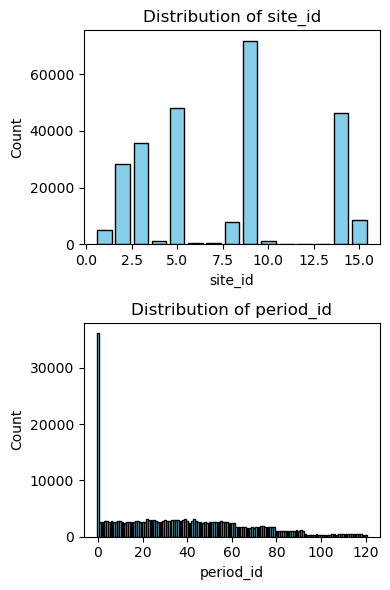

In [11]:
selected_features = ['site_id', 'period_id'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(4, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    
    axs[i].bar(categories, counts, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

In [12]:
# Создаем VectorAssembler для объединения признаков в один вектор
feature_cols = ['load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95']  
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(cleaned_dataframe)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Выводим матрицу корреляции
correlation_df = pd.DataFrame(correlation_array, columns=feature_cols)

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

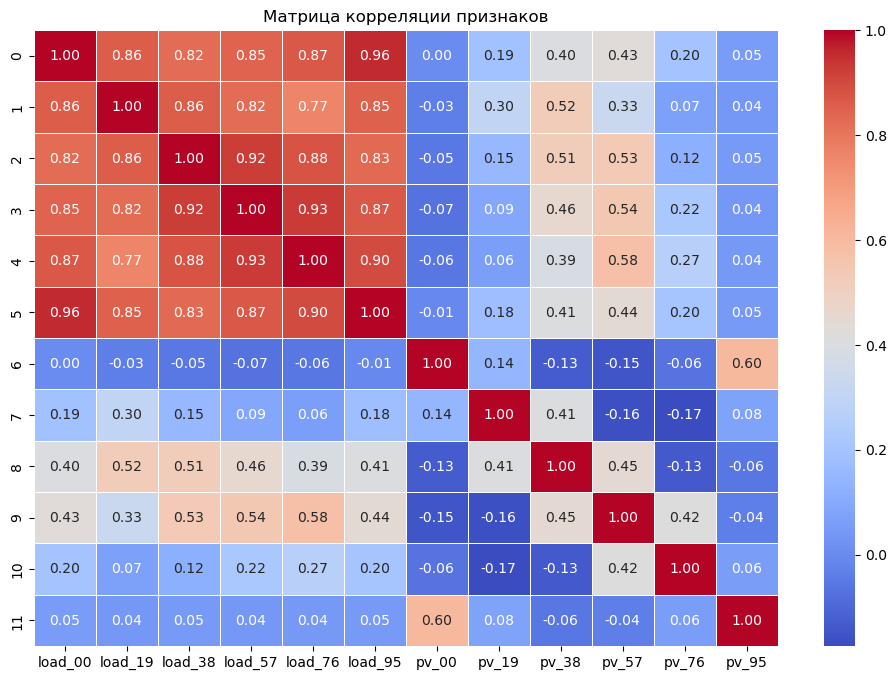

In [13]:
# Строим тепловую карту корреляции с использованием Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

In [14]:
# Определяем окно сортировки по полю 'timestamp'
windowSpec = Window.orderBy(desc("timestamp"))

# Добавляем столбцы с лагами и лидами для 'load_00'
data_with_lag_lead = cleaned_dataframe.withColumn("lag_load_00", lag("load_00").over(windowSpec)) \
                            .withColumn("lead_load_00", lead("load_00").over(windowSpec))

# Группируем данные по 'timestamp' и аггрегируем с использованием desc сортировки
last_three_timestamps = data_with_lag_lead.groupBy("timestamp") \
                                          .agg(count("timestamp").alias("count")) \
                                          .orderBy(desc("timestamp")) \
                                          .limit(3)

# Присоединяем последние три метки времени к данным
latest_rows = data_with_lag_lead.join(last_three_timestamps, "timestamp")

result = latest_rows.withColumn("avg_load_00", (col("lag_load_00") + col("lead_load_00") + col("load_00")) / 3) \
                          .select("timestamp", "load_00", "lag_load_00", "lead_load_00", "avg_load_00")

# Выводим результат
result.show()

+-------------------+------------------+------------------+------------------+------------------+
|          timestamp|           load_00|       lag_load_00|      lead_load_00|       avg_load_00|
+-------------------+------------------+------------------+------------------+------------------+
|2017-10-21 23:45:00| 9.485006903820448|              NULL| 6.224997008085698|              NULL|
|2017-10-21 23:45:00| 6.224997008085698| 9.485006903820448|25.504997606821835|13.738333839575992|
|2017-10-21 23:30:00|25.504997606821835| 6.224997008085698| 9.152194249568677|13.627396288158735|
|2017-10-21 23:30:00| 9.152194249568677|25.504997606821835| 5.610520245340206|13.422570700576907|
|2017-10-21 23:30:00| 5.610520245340206| 9.152194249568677|25.424246606520185|13.395653700476357|
|2017-10-21 23:15:00|25.424246606520185| 5.610520245340206| 8.971320432685742|13.335362428182044|
|2017-10-21 23:15:00| 8.971320432685742|25.424246606520185|  5.88450248407416|13.426689841093363|
|2017-10-21 23:15:00

In [15]:
# Сохраним преобразованный датафрейм в csv-файл.
cleaned_dataframe.coalesce(1).write.options(header='True', delimiter=';').csv('filtered_data/data')

# Закрываем сессию Spark
spark.stop()